### Predictive Maintenance - EDA Script

Purpose of this script is to demonstrate some EDA techniques on the NASA CMAPSS Jet Engine Simulated Data, which will ultimately be used to carry out forecasting of the Remaining Useful Life (RUL) of the engines whilst also detecting anomalies in the engine performance data.

This notebook will walk you through the following steps:

1. Importing Libraries necessary for carrying out EDA
2. Load and inspect the data
3. Data cleaning
4. Data exploration and Visualisation
5. Multivariate and Correlation Analysis

#### 1. Import Libraries for carrying out EDA

In [39]:
# Import Necessary Libraries

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.impute import SimpleImputer
import io
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore', category=FutureWarning) # Removes "Future Warining" messages from being displayed


#### 2. Load and inspect the data

In [23]:
# Set the base folder where your data is located
BASE_DIR = Path("C:/Users/Stuart/predictive_maintenance/data/raw")

# Load the raw training and test data
df_train = pd.read_csv(BASE_DIR / "train_FD001.txt", sep="\s+", header=None)
df_test = pd.read_csv(BASE_DIR / "test_FD001.txt", sep="\s+", header=None)
df_rul = pd.read_csv(BASE_DIR / "RUL_FD001.txt", sep="\s+", header=None)

# Display the first 5 rows of the train dataset to ensure the data has loaded correctly
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Following our initial manual review of the data we know that there are no column names assigned to our data so the first step now that we've loaded this is to add the names to each column before we begin working on our EDA.

The column names are as follows:

**df_rul**: Remaining Useful Life

**df_test** & **df_train**

1. **Unit Number**: Engine unit number
2. **Time**: Time in cycles
3. **Operational Setting 1**: Operational setting
4. **Operational Setting 2**: Operational setting
5. **Operational Setting 3**: Operational setting
6. **Sensor Measurement 1 - 21**: Sensor measurements


We’ll now programmatically assign these column names to the dataframes to prepare for further analysis. It's worth noting that the sensor columns (sensor_1 to sensor_21) are quite generic, and their names provide little insight into the type of measurement they represent.  As part of our EDA, we’ll explore these sensor readings to identify which ones carry meaningful signals relevant to our task, and consider appropriate preprocessing steps such as filtering out static or uninformative features.

In [24]:
# Add the column names to the dataframes
columns = (
    ['unit', 'time'] +
    [f'op_setting_{i}' for i in range(1, 4)] +
    [f'sensor_{i}' for i in range(1, 22)]
)

df_train.columns = columns
df_test.columns = columns
df_rul.columns = ['RUL']

# Add a processed directory to save the processed data
# This will help keep the raw and processed data separate
PROCESSED_DIR = BASE_DIR.parent / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)  # Create the folder if it doesn't exist

# Next we'll save the dataframes to CSV files for further analysis
df_train.to_csv(PROCESSED_DIR / "train_FD001.csv", index=False)
df_test.to_csv(PROCESSED_DIR / "test_FD001.csv", index=False)
df_rul.to_csv(PROCESSED_DIR / "rul_FD001.csv", index=False)

# Display the first 5 rows of the train dataset to ensure the data has loaded correctly
df_train.head()

,unit,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Now that we've successfully created fresh dataframes with each of the columns correctly labelled we'll now begin our EDA.

In [28]:
# Use the info method to get basic information on the dataset
# Define function to capture .info() output
def capture_info(df):
    buffer = io.StringIO()
    df.info(buf=buffer)
    return buffer.getvalue()

# Define display function for multiple datasets
def display_dataset_infos(*dfs, names=None):
    for i, df in enumerate(dfs):
        name = names[i] if names else f"Dataset {i+1}"
        print(f"\n========== {name} Info ==========\n")
        print(capture_info(df))

# Display info for all three datasets
display_dataset_infos(df_train, df_test, df_rul, names=["Train", "Test", "RUL"])


========== Train Info ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit          20631 non-null  int64  
 1   time          20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  floa

In [21]:
# Use the shape method to display how many rows and columns the dataset has
print("Shape of training data:", df_train.shape)

# Use the describe method to display the summary stats for the dataset
print("\nSummary statistics of training data:")
display(df_train.describe(include="all"))

Shape of training data: (20631, 26)

Summary statistics of training data:


,unit,time,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


#### 3. Data Cleaning

In this section, we'll begin preparing our data for further analysis by performing basic cleaning tasks.  While the CMAPSS dataset is relatively well-structured, it's still important to check for any uninformative or redundant features that may interfere with effective analysis.

Although this notebook is focused on EDA, the steps we take here, such as identifying sensors with no variation are also valuable if the dataset were later to be used for modelling.

We'll focus on:
- Checking for null or missing values
- Identifying and removing sensors with constant or near-constant values

This initial cleanup helps ensure our analysis is based on meaningful and reliable signals.

In [32]:
# Check for null values in each dataset
def check_nulls(*dfs, names=None):
    for i, df in enumerate(dfs):
        name = names[i] if names else f"Dataset {i+1}"
        print(f"\n========== {name} Null Summary ==========\n")
        print(df.isnull().sum())

check_nulls(df_train, df_test, df_rul, names=["Train", "Test", "RUL"])


========== Train Null Summary ==========

unit            0
time            0
op_setting_1    0
op_setting_2    0
op_setting_3    0
sensor_1        0
sensor_2        0
sensor_3        0
sensor_4        0
sensor_5        0
sensor_6        0
sensor_7        0
sensor_8        0
sensor_9        0
sensor_10       0
sensor_11       0
sensor_12       0
sensor_13       0
sensor_14       0
sensor_15       0
sensor_16       0
sensor_17       0
sensor_18       0
sensor_19       0
sensor_20       0
sensor_21       0
dtype: int64

========== Test Null Summary ==========

unit            0
time            0
op_setting_1    0
op_setting_2    0
op_setting_3    0
sensor_1        0
sensor_2        0
sensor_3        0
sensor_4        0
sensor_5        0
sensor_6        0
sensor_7        0
sensor_8        0
sensor_9        0
sensor_10       0
sensor_11       0
sensor_12       0
sensor_13       0
sensor_14       0
sensor_15       0
sensor_16       0
sensor_17       0
sensor_18       0
sensor_19       0
se

In [33]:
# Identify constant columns (same value across all rows)
constant_columns = [col for col in df_train.columns if df_train[col].nunique() == 1]

print("Constant columns found:", constant_columns)

# Drop constant columns from train and test sets
df_train_cleaned = df_train.drop(columns=constant_columns)
df_test_cleaned = df_test.drop(columns=constant_columns)

Constant columns found: ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']


As can be seen the columns that we've identified as having constant values are:

1. op_setting_3
2. sensor_1
3. sensor_5
4. sensor_10
5. sensor_16
6. sensor_18
7. sensor_19

In this context, a “constant” column is one where the value remains the same across all rows.  Since these features don’t provide any variability, they offer no useful information for analysis or modelling.  As such, it makes sense to remove them from both the training and test datasets.

Given that we've now cleaned our dataset, it is good practice to save it so it can then be used at a later stage without having to carry out the data cleaning steps again.

In [34]:
# Define a path for the cleaned dataset
# It's good practice to save it to a new file, perhaps in a 'cleaned' directory
CLEANED_DIR = BASE_DIR.parent / "cleaned"
CLEANED_DIR.mkdir(parents=True, exist_ok=True)  # Create the folder if it doesn't exist

# Save the cleaned DataFrame to a new CSV file
# index=False prevents pandas from writing the DataFrame index as a column in the CSV
# Save the cleaned DataFrame to new CSV files
df_train_cleaned.to_csv(CLEANED_DIR / "train_FD001_cleaned.csv", index=False)
df_test_cleaned.to_csv(CLEANED_DIR / "test_FD001_cleaned.csv", index=False)


print(f"Cleaned dataset saved successfully to: {CLEANED_DIR}")

Cleaned dataset saved successfully to: C:\Users\Stuart\predictive_maintenance\data\cleaned


#### 4. Data Exploration and Visualisation

Now that we've cleaned our dataset, the next step is to explore its structure and characteristics.  This will help us better understand the operating conditions and sensor behaviour over time, form early hypotheses, and surface any patterns that may be useful for downstream tasks like modeling or anomaly detection.

We'll start by analysing each feature individually (univariate analysis), then gradually move toward exploring relationships between features (bivariate or multivariate analysis).

##### Univariate Analysis: Understanding Individual Features

Univariate analysis allows us to understand the distribution and behavior of each feature in isolation.  Since our dataset is entirely numerical and includes time-series sensor readings, we'll focus on statistical properties and visual summaries.

##### Numerical Features: Distribution and Range

To better understand the distribution of values across the different sensors and operating settings, we’ll use:

- **Histograms**: to observe frequency and skewness of values.  
- **KDE (Kernel Density Estimation) plots**: for a smoothed view of value distributions.  
- **Box plots**: to highlight spread, median, and outliers (useful for spotting drift or sensor anomalies).

We’ll also look at the **range and variance** of features to identify those with limited variation, which may affect later modeling stages.


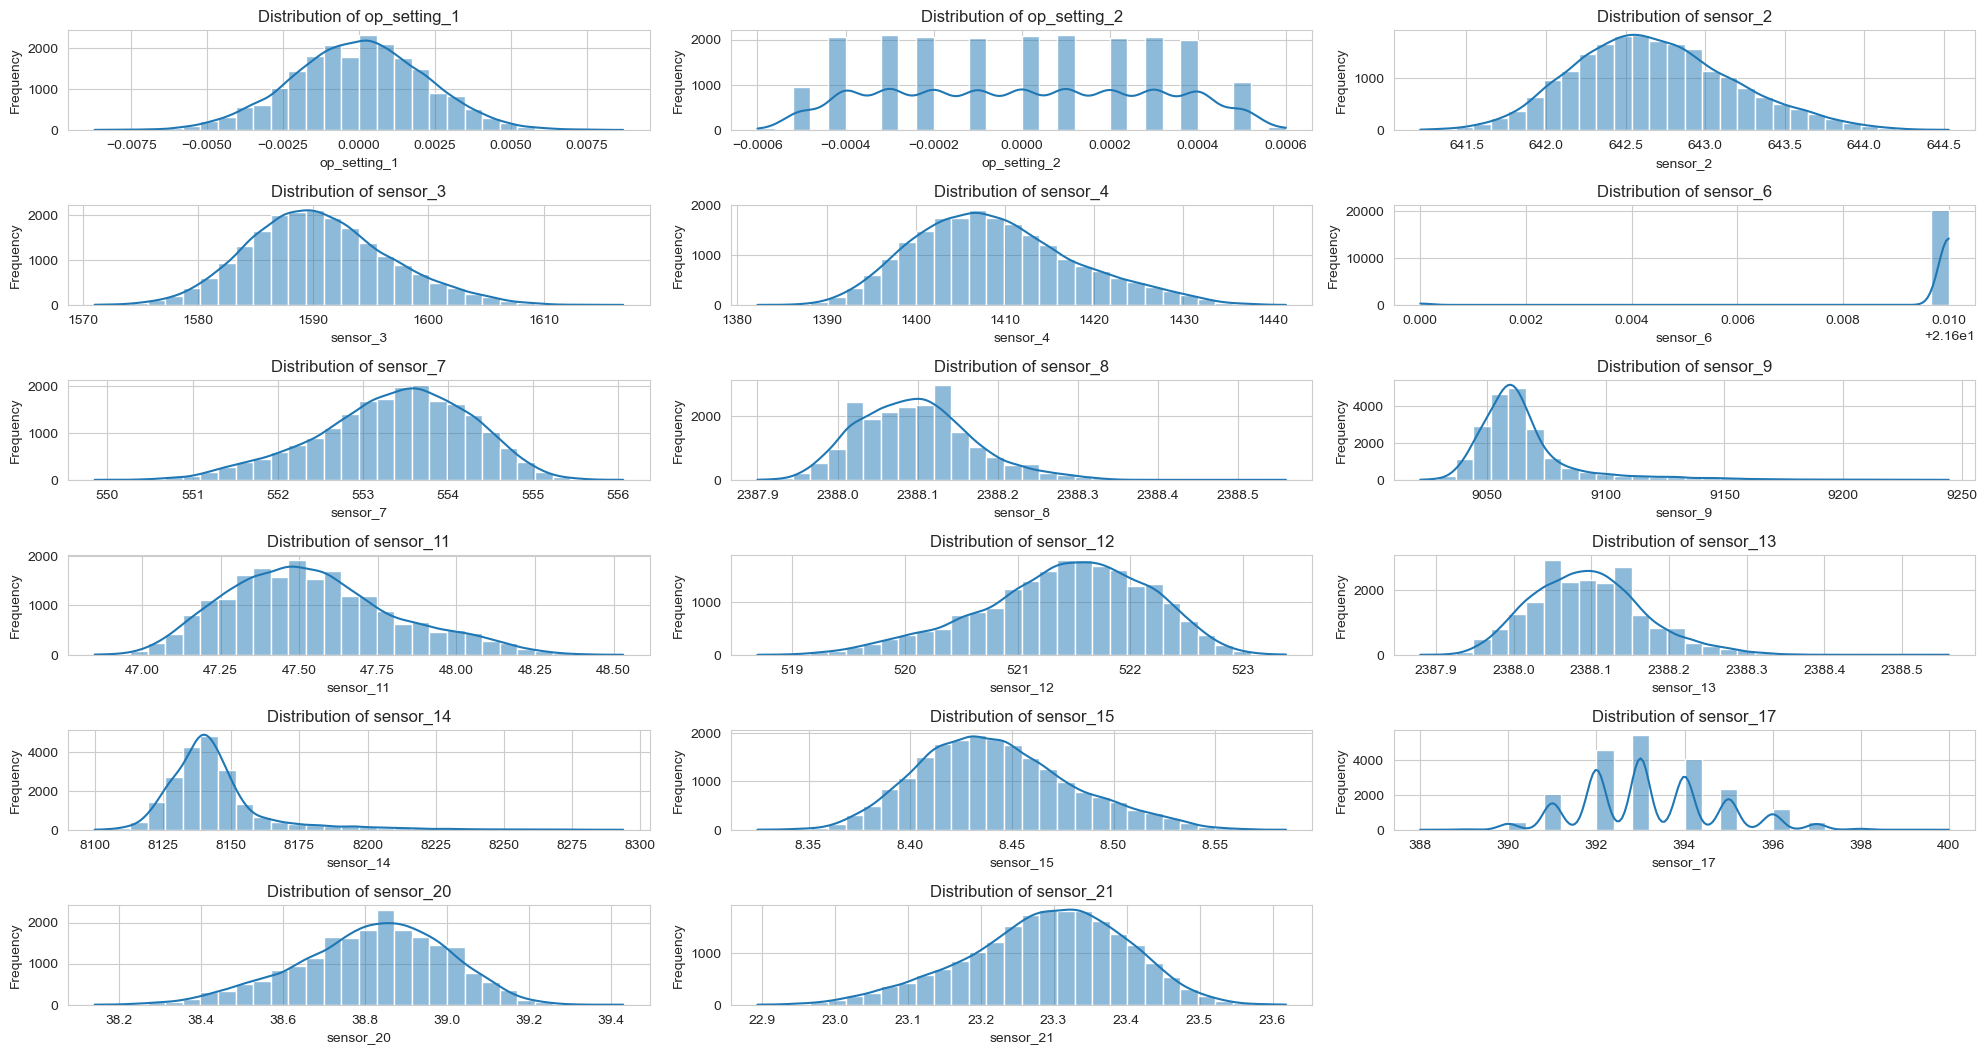

In [37]:
# Set a style for the plots for better aesthetics
sns.set_style("whitegrid")

# List of columns to plot — operational settings + sensor measurements
columns_to_plot = [col for col in df_train_cleaned.columns if col.startswith('sensor_') or col.startswith('op_setting_')]


# Plot histograms with KDE for each feature
plt.figure(figsize=(20, 12))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(7, 3, i)  # Adjust rows/cols based on total plots
    sns.histplot(df_train_cleaned[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


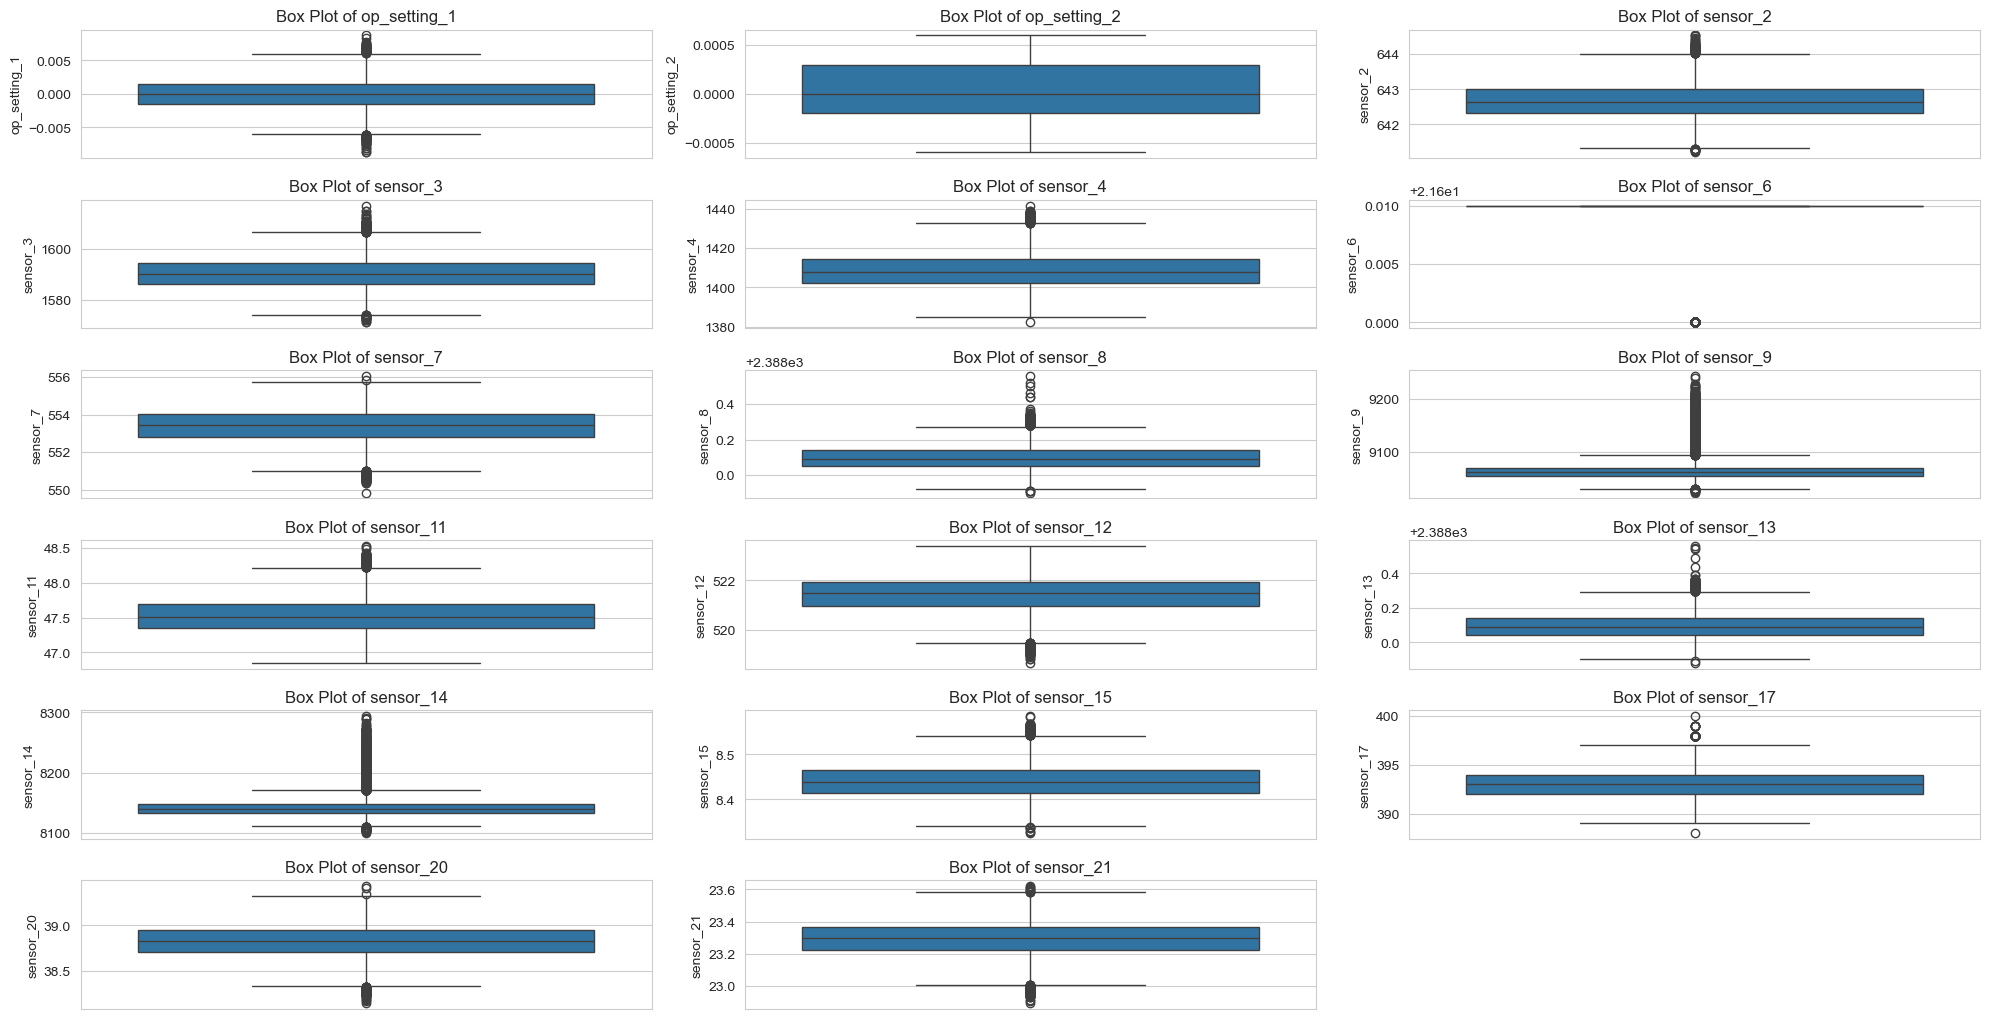

In [38]:
# Plot box plots to check for spread and outliers
plt.figure(figsize=(20, 12))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(7, 3, i)
    sns.boxplot(y=df_train_cleaned[col])
    plt.title(f"Box Plot of {col}")
    plt.ylabel(col)
plt.tight_layout()
plt.show()

#### Observations from Univariate Analysis

The histograms and box plots highlight several important points about the sensor data:

- Most features appear to follow unimodal, roughly symmetric distributions.
- A few sensors, particularly `sensor_9`, `sensor_14`, and `sensor_17` display notable skewness, outliers, or multimodal behavior. This suggests that they may be capturing complex dynamics such as degradation signals or regime shifts.

From a non-domain-expert perspective (e.g. without prior knowledge of jet engine internals), these patterns are striking enough to warrant further investigation.  If subject matter expertise (e.g. from NASA engineers) were available, the next logical step would be to understand:

- What exactly are these sensors measuring?
- Are the observed variations in their readings tied to specific components or failure modes?
- Are they known to correlate with wear, stress, or operational anomalies?

Such contextual understanding would help guide downstream feature selection, model interpretation, and even how we engineer labels for predicting Remaining Useful Life (RUL).

##### Additional Sensor Insights

While `sensor_9`, `sensor_14`, and `sensor_17` stand out due to their pronounced skew and broader spread, potentially indicating critical deterioration patterns it's worth noting that `sensor_8` and `sensor_13` also display **right-skewed distributions**.

This suggests that although most engines operate within a normal range, some show **elevated values** that may be associated with progressive degradation. Even though the skew is more subtle, these features might still provide **early warning signals** when analysed in a time-series or multivariate context.

Therefore, we will retain these sensors for further analysis to determine whether they contribute meaningfully to predicting Remaining Useful Life (RUL).

##### Outlier Consideration

During the univariate analysis, several sensors (notably `sensor_9`, `sensor_14`, and `sensor_17`) showed extreme values beyond the expected range, suggesting potential outliers.

Rather than immediately removing or capping these values, we will:

1. **Retain them for now** to observe whether they align with failure proximity in the time-series.
2. **Examine their temporal context**: Do these outliers occur toward the end of the engine’s life? If so, they may be vital degradation signals.
3. **Flag potential anomalies**: If they appear abruptly or inconsistently without clear progression, they may be candidates for further cleaning.

This approach avoids prematurely discarding data that might be crucial for RUL prediction, while still allowing us to flag and handle true anomalies later in the pipeline.


#### **Bonus Section** Focused Sensor Analysis for Predictive Maintenance

Based on the previous univariate exploration, we identified a subset of sensors that warrant deeper investigation:

- `sensor_8`, `sensor_9`, `sensor_13`, `sensor_14`, and `sensor_17`

These sensors exhibit patterns that may reflect important degradation signals.

This section will:

 1. Visualise sensor readings over time per engine unit.
 2. Compute rolling statistics (mean, std) to detect trends and regime changes.
 3. Flag potential outliers based on z-scores.
 4. Analyse the temporal distribution of outliers, especially near end-of-life cycles.

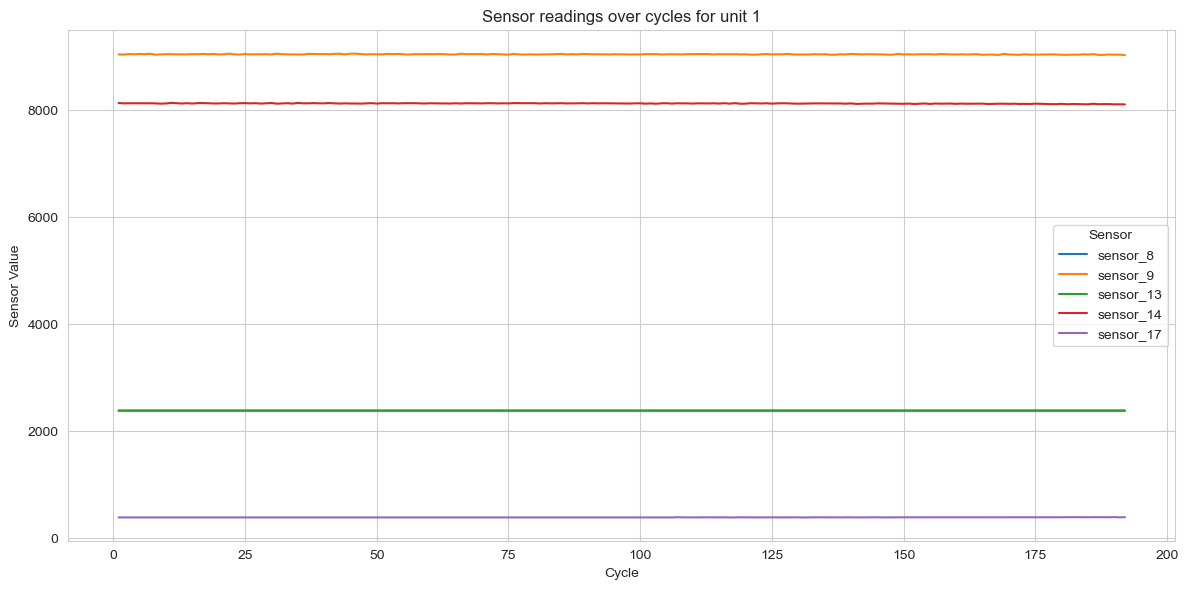

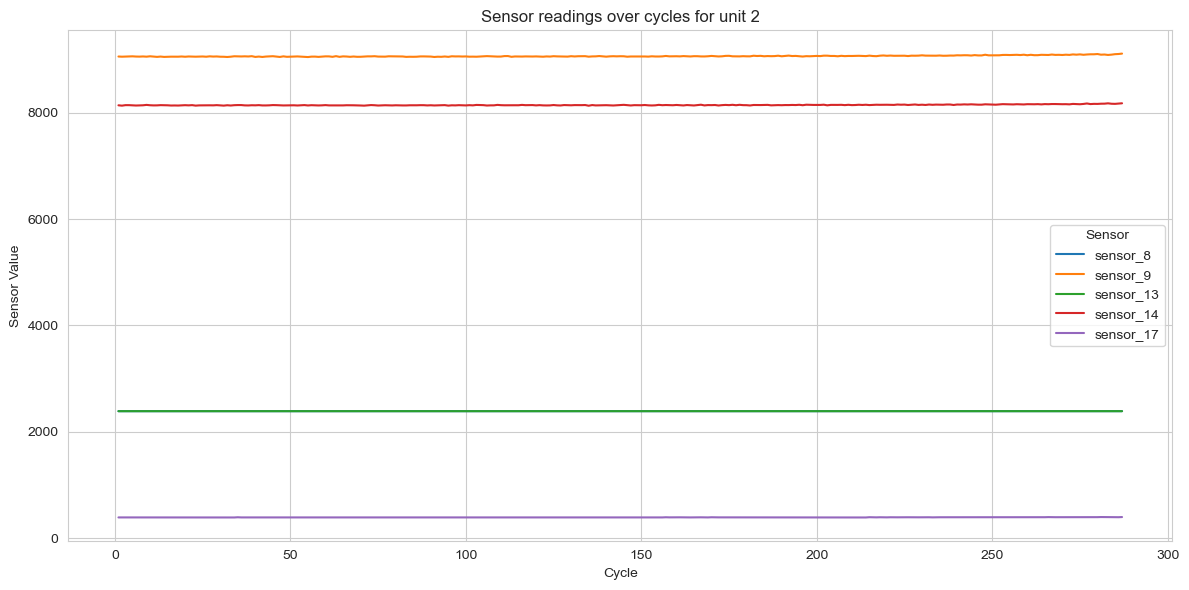

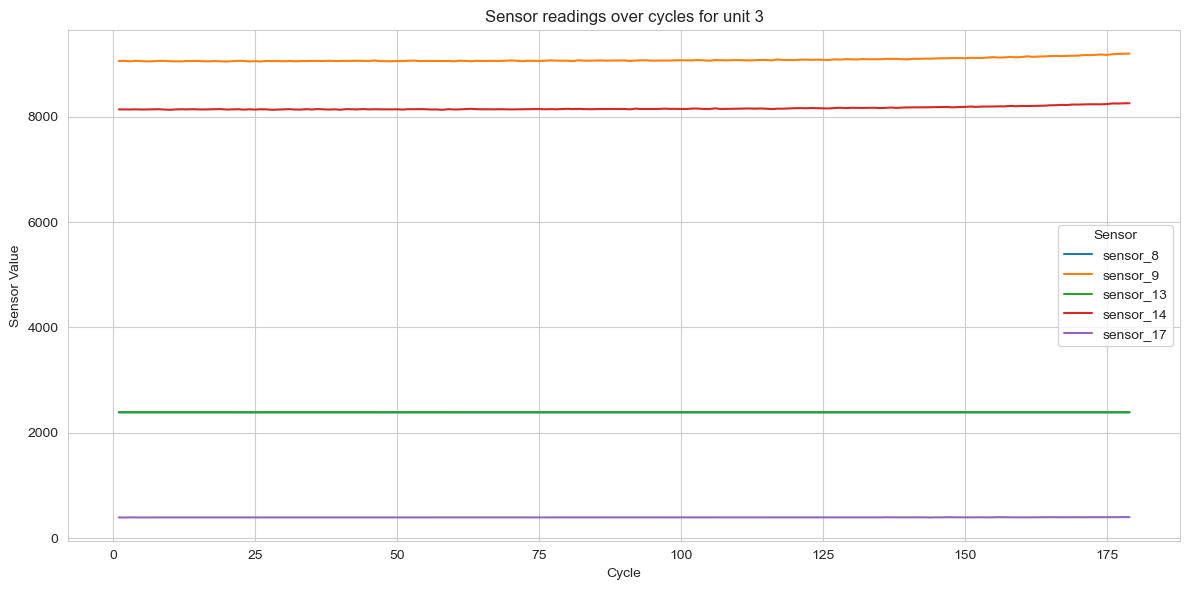

In [46]:
# Sensors of interest
sensor_cols = ['sensor_8', 'sensor_9', 'sensor_13', 'sensor_14', 'sensor_17']

# Function: Plot sensor readings over cycles for selected units
def plot_sensor_time_series_seaborn(df, unit_ids, sensor_cols):
    """
    Plot time series of selected sensors using seaborn for specified engine units.

    Parameters:
        df (pd.DataFrame): DataFrame containing sensor data with 'unit' and 'time' columns.
        unit_ids (list): List of engine unit IDs to plot.
        sensor_cols (list): List of sensor column names to include.
    """
    for unit in unit_ids:
        df_unit = df[df['unit'] == unit]
        df_melted = df_unit.melt(id_vars='time', value_vars=sensor_cols,
                                 var_name='Sensor', value_name='Value')
        
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=df_melted, x='time', y='Value', hue='Sensor')
        plt.title(f'Sensor readings over cycles for unit {unit}')
        plt.xlabel('Cycle')
        plt.ylabel('Sensor Value')
        plt.legend(title='Sensor')
        plt.tight_layout()
        plt.show()

# Example usage
sample_units = df_train_cleaned['unit'].unique()[:3]
plot_sensor_time_series_seaborn(df_train_cleaned, sample_units, sensor_cols)

#### Interpreting the plots

These plots help us visually assess sensor behavior throughout the engine's operational cycles.

We look for trends such as gradual increases/decreases, sudden spikes, or irregular fluctuations.

In particular, note if outliers or spikes appear predominantly near the end of engine life, as these may signal critical degradation.

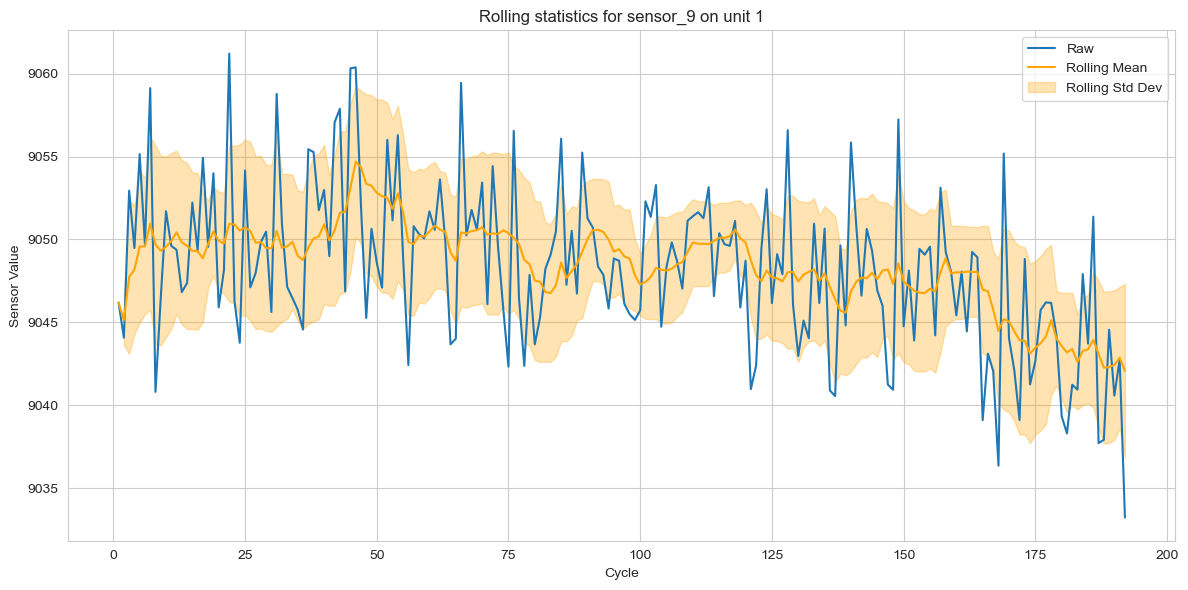

In [ ]:
# Function: Add rolling mean and rolling std deviation columns per unit for sensors of interest
def add_rolling_stats(df, sensor_cols, window=10):
    """
    Adds rolling mean and std dev per sensor per engine unit.

    Parameters:
        df (pd.DataFrame): Must include 'unit', 'time' and sensor_cols.
        sensor_cols (list): Sensors to compute rolling stats on.
        window (int): Rolling window size.

    Returns:
        pd.DataFrame: New DataFrame with rolling mean and std columns.
    """
    df_rolled = df.copy()
    for sensor in sensor_cols:
        df_rolled[f'{sensor}_rolling_mean'] = df_rolled.groupby('unit')[sensor] \
            .transform(lambda x: x.rolling(window, min_periods=1).mean())
        df_rolled[f'{sensor}_rolling_std'] = df_rolled.groupby('unit')[sensor] \
            .transform(lambda x: x.rolling(window, min_periods=1).std())
    return df_rolled

# Add rolling stats
df_train_rolled = add_rolling_stats(df_train_cleaned, sensor_cols, window=10)

# Example for one unit and one sensor
unit_example = sample_units[0]
sensor_example = 'sensor_9'

df_unit = df_train_rolled[df_train_rolled['unit'] == unit_example]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_unit, x='time', y=sensor_example, label='Raw')
sns.lineplot(data=df_unit, x='time', y=f'{sensor_example}_rolling_mean', label='Rolling Mean', color='orange')

# Shaded rolling std dev
plt.fill_between(
    df_unit['time'],
    df_unit[f'{sensor_example}_rolling_mean'] - df_unit[f'{sensor_example}_rolling_std'],
    df_unit[f'{sensor_example}_rolling_mean'] + df_unit[f'{sensor_example}_rolling_std'],
    color='orange', alpha=0.3, label='Rolling Std Dev'
)

plt.title(f'Rolling statistics for {sensor_example} on unit {unit_example}')
plt.xlabel('Cycle')
plt.ylabel('Sensor Value')
plt.legend()
plt.tight_layout()
plt.show()

#### Rolling statistics insights

The rolling mean smooths out short-term noise, helping us identify longer-term trends or regime shifts.  The shaded area representing rolling standard deviation shows how sensor variability evolves over time.  Elevated variance towards the end of the engine life may indicate unstable or failing components.


In [42]:
# Function: Flag outliers per sensor per unit using z-score
def flag_sensor_outliers(df, sensor_cols, z_thresh=3):
    """
    Flags outliers based on z-score threshold for each sensor per engine unit.

    Parameters:
        df (pd.DataFrame): DataFrame with sensor data and 'unit'.
        sensor_cols (list): Sensors to analyze.
        z_thresh (float): Z-score threshold to define outliers.

    Returns:
        pd.DataFrame: DataFrame with additional boolean columns '{sensor}_outlier'.
    """
    df_flagged = df.copy()
    for sensor in sensor_cols:
        df_flagged[f'{sensor}_zscore'] = df_flagged.groupby('unit')[sensor].transform(zscore)
        df_flagged[f'{sensor}_outlier'] = df_flagged[f'{sensor}_zscore'].abs() > z_thresh
    return df_flagged

# Apply outlier flagging
df_train_flagged = flag_sensor_outliers(df_train_rolled, sensor_cols, z_thresh=3)

# Add 'cycles_remaining' column for end-of-life analysis
df_train_flagged['cycles_remaining'] = df_train_flagged.groupby('unit')['time'].transform('max') - df_train_flagged['time']

# Summarise number of outliers near end-of-life for each sensor
print("Outliers near end-of-life (last 20% cycles) per sensor:\n")
threshold_fraction = 0.2

for sensor in sensor_cols:
    max_cycles = df_train_flagged.groupby('unit')['time'].transform('max')
    threshold_cycles = max_cycles * threshold_fraction
    near_end_outliers = df_train_flagged[
        (df_train_flagged[f'{sensor}_outlier']) & 
        (df_train_flagged['cycles_remaining'] <= threshold_cycles)
    ]
    print(f"{sensor}: {len(near_end_outliers)}")

Outliers near end-of-life (last 20% cycles) per sensor:

sensor_8: 83
sensor_9: 159
sensor_13: 76
sensor_14: 169
sensor_17: 70


#### Outlier temporal analysis
 
Counting outliers near the end of engine life allows us to evaluate whether extreme sensor values are related to degradation.  A high concentration of outliers near failure cycles supports their importance as predictive signals.  Conversely, scattered or early outliers might indicate noise or data quality issues requiring further cleaning.

#### 5. Multivariate and Correlation Analysis

##### Why Include correlation/multivariate analysis?

**Sensor Redundancy**
Jet engine sensor data often contains highly correlated features. For example, two temperature or pressure sensors might respond to similar underlying phenomena. A correlation matrix helps identify:

Which sensors are essentially duplicating information (and could be dropped or compressed),

Which are providing independent signal (more valuable for RUL prediction).

**Interaction Effects**
Some features only become meaningful when considered together (e.g. sensor_14 rises only when sensor_8 drops). You won’t see this in univariate plots.

**Dimensionality Reduction Prep**
If you're later going to apply PCA, autoencoders, or other feature reduction methods (common in MLOps workflows), then identifying multicollinearity now helps plan your pipeline.

**Model Feature Importance Validation**
Correlation matrices or pair plots now will help explain or validate why a model later considers certain sensors as more/less predictive.

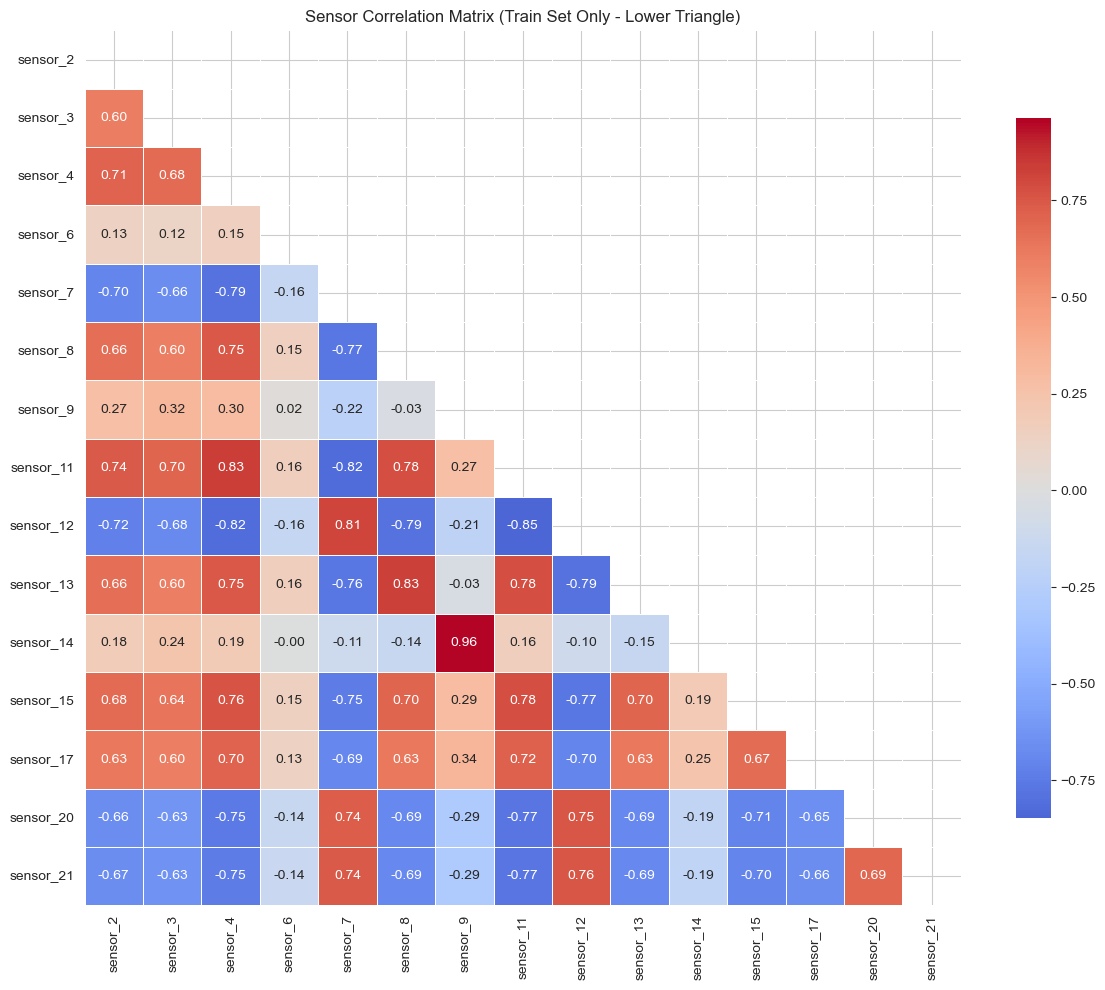

In [45]:
# Select only the sensor columns from the cleaned DataFrame
sensor_cols = [col for col in df_train_cleaned.columns if 'sensor_' in col]
sensor_data = df_train_cleaned[sensor_cols]

# Compute correlation matrix
corr_matrix = sensor_data.corr()

# Create a mask to show only the lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Sensor Correlation Matrix (Train Set Only - Lower Triangle)")
plt.tight_layout()
plt.show()

We use only the training set (`df_train_cleaned`) to explore sensor correlations to prevent any potential data leakage.  The test set is assumed to follow a similar distribution, so any strong relationships we observe here should generalise. 

This heatmap helps identify:
- Redundant sensors (correlation > 0.9 or < -0.9)
- Uncorrelated features (potentially useful independent predictors)

So in our correlation matrix, you can see that `sensor_14` and `sensor_9` exhibit a very high correlation, which can often mean that they are carrying very similar information.  This introduces `multicoliarity`, which can:

- Inflate variance in coefficent estimates if we decide to use a linear model later.
- Reduce the interpretability of the model.
- Increase the risk of overfitting, especailly with simple models.

There are a number of ways to deal with this such as:

- Dropping one of them (you could retain the one with stronger univariate or temporal signals).
- Compare predictive power (test individually in simple models to see which is more predictive).
- Use feature selection to determine which to retain.


#### Summary of EDA Findings
 
After conducting a thorough exploratory analysis of the data, several key observations were made:

**General Data Quality**  
The datasets were generally well-structured, with no missing values. However, the initial files downloaded contained no column headings, and as a result these had to be added to ensure the data could be properly worked with.

**Sensor Behavior**  
During the initial analysis of the data, several columns were identified as having constant or near-constant values; `op_setting_3`, `sensor_1`, `sensor_5`, `sensor_10`, `sensor_16`, `sensor_18`, and `sensor_19`. This suggests they may not contribute much predictive value and were removed from the datasets.

Temporal plots indicated some sensors showed meaningful degradation or drift patterns over time, particularly relevant for Remaining Useful Life (RUL) modeling.

**Correlation Patterns**  
Strong correlations (e.g., `sensor_14` and `sensor_9`, corr ≈ 0.96) suggest multicollinearity, which could affect model interpretability and stability.

Some sensors appeared independent, which could be valuable for model diversity.

#### Next Steps

Based on the insights from the EDA, the following steps are recommended to prepare for modeling:

- **Refine Feature Set**  
  Consider removing one of the highly correlated sensors (e.g., `sensor_9` or `sensor_14`) to reduce multicollinearity, especially if using linear models.

- **Feature Engineering**  
  Develop additional time-based features such as rolling averages, deltas, or trend indicators to capture degradation behaviour more explicitly.

- **Target Definition and Labeling**  
  Define the prediction target(s), for example:
  - Remaining Useful Life (RUL) for regression.
  - Binary failure window classification (e.g., failure within next *n* cycles).

- **Validation Strategy**
While the CMAPSS dataset provides a separate test set and true RUL values, consider holding out a portion of the training engines for validation to tune models and avoid overfitting. Grouped validation (e.g., by engine ID) is recommended due to the time-series nature of the data.

- **Model Baseline**  
  Begin with simple models (e.g., linear regression, random forest) to establish baseline performance, and iterate from there.

- **Optional: Sensor Selection Refinement**  
  Evaluate the predictive contribution of each sensor through SHAP, permutation importance, or univariate models if needed.